# Fine-tuning and quantization-aware training of a speechbrain model

## Installing Dependencies

In [166]:
%%capture
!pip install speechbrain

In [167]:
%%capture
import speechbrain
!wget https://www.dropbox.com/s/b61lo6gkpuplanq/MiniLibriSpeechTutorial.tar.gz?dl=0
!tar -xvzf MiniLibriSpeechTutorial.tar.gz?dl=0
!wget https://www.openslr.org/resources/31/dev-clean-2.tar.gz
!tar -xvzf dev-clean-2.tar.gz

### Automatic Speech Recognition

This ASR pipeline is made of three components as detailed [here](https://huggingface.co/speechbrain/asr-crdnn-rnnlm-librispeech):


1.   a CRDNN-based seq2seq E2E ASR model trained following this [recipe](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech/ASR/seq2seq).
2.   a RNN-based LM.
3.   a SentencePiece Tokenizer object needed transforms words into subword units.

In [170]:
from speechbrain.pretrained import EncoderDecoderASR
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="./pretrained_ASR")

## Fine-tuning a pretrained model

Here we will show how to fine-tune the CRDNN Encoder Decoder Seq2Seq model used to transcribe the audio in the previous example and downloaded from [here](https://huggingface.co/speechbrain/asr-crdnn-rnnlm-librispeech/blob/main/hyperparams.yaml).






In [192]:
from speechbrain.pretrained import EncoderDecoderASR
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="./pretrained_ASR")

First we can see that the pretrained `asr_model` allows to access easily all its components:


In [ ]:
asr_model.mods.keys()

These keys corresponds to the modules entry specified in the [hyperparameter file](https://huggingface.co/speechbrain/asr-crdnn-rnnlm-librispeech/blob/main/hyperparams.yaml):


```yaml
modules:
    encoder: !ref <encoder>
    decoder: !ref <decoder>
    lm_model: !ref <lm_model>
```

We can also see that the encoder is actually composed of several sub-modules:

```yaml
encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalize>
    model: !ref <enc>
```



These are simply accessible as members of the encoder:

In [197]:
asr_model.mods.encoder.compute_features

Fbank(
  (compute_STFT): STFT()
  (compute_fbanks): Filterbank()
  (compute_deltas): Deltas()
  (context_window): ContextWindow()
)

Such information are pretty useful as we can directly use some of these hyperparameters in our fine-tuning pipeline to ensure compability with the pretrained model (e.g. use the same BOS or EOS indexes)!

### Setting up the data pipeline

First we must set up the data pipeline for downloaded MiniLibriSpeech data.

If you are not familiar with **SpeechBrain dataIO** you may want to take a look at the [tutorial](https://colab.research.google.com/drive/1AiVJZhZKwEI4nFGANKXEe-ffZFfvXKwH).

In [198]:
import speechbrain as sb
import torch

We parse MiniLibriSpeech to a suitable JSON annotation

In [182]:
from parse_data import parse_to_json
parse_to_json("./LibriSpeech/dev-clean-2")

We instantiate a **DynamicItemDataset** from the JSON annotation

In [183]:
from speechbrain.dataio.dataset import DynamicItemDataset
dataset = DynamicItemDataset.from_json("data.json")

We sort the dataset based on length to speed-up training

In [184]:
dataset = dataset.filtered_sorted(sort_key="length", select_n=100)

and add a pipeline for reading audio

In [185]:
dataset.add_dynamic_item(sb.dataio.dataio.read_audio, takes="file_path", provides="signal")

and another one to encode the words from annotation.

In [199]:
# 3. Define text pipeline:
@sb.utils.data_pipeline.takes("words")
@sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens")
def text_pipeline(words):
      yield words
      tokens_list = asr_model.tokenizer.encode_as_ids(words)
      yield tokens_list
      tokens_bos = torch.LongTensor([asr_model.hparams.bos_index] + (tokens_list))
      yield tokens_bos
      tokens_eos = torch.LongTensor(tokens_list + [asr_model.hparams.eos_index]) # we use same eos and bos indexes as in pretrained model
      yield tokens_eos
      tokens = torch.LongTensor(tokens_list)
      yield tokens

In [200]:
dataset.add_dynamic_item(text_pipeline)

We set the dataset object to return the signal tensor as well as the encoded tokens and words.

In [201]:
dataset.set_output_keys(["id", "signal", "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"])

### Fine-Tuning the ASR model

First, We define our Brain class that will perform the fine-tuning. Here, we just take an example similar to the Brain class of the original [Seq2Seq LibriSpeech recipe](https://github.com/speechbrain/speechbrain/blob/develop/recipes/LibriSpeech/ASR/seq2seq/train.py).


In [202]:
from speechbrain.lobes.features import Fbank
import torch

# Define fine-tuning procedure
class EncDecFineTune(sb.Brain):

    def on_stage_start(self, stage, epoch):
        # enable grad for all modules we want to fine-tune
        if stage == sb.Stage.TRAIN:
            for module in [self.modules.enc, self.modules.emb, self.modules.dec, self.modules.seq_lin]:
                for p in module.parameters():
                    p.requires_grad = True

    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.signal
        tokens_bos, _ = batch.tokens_bos
        wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)

        # Forward pass
        feats = self.modules.compute_features(wavs)
        feats = self.modules.normalize(feats, wav_lens)
        #feats.requires_grad = True
        x = self.modules.enc(feats)

        e_in = self.modules.emb(tokens_bos)  # y_in bos + tokens
        h, _ = self.modules.dec(e_in, x, wav_lens)

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(h)
        p_seq = self.hparams.log_softmax(logits)

        return p_seq, wav_lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""


        p_seq, wav_lens = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        loss = self.hparams.seq_cost(
            p_seq, tokens_eos, tokens_eos_lens)


        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)
        loss.backward()
        if self.check_gradients(loss):
            self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.detach()


Here we define the modules and hyperparameters needed for the Brain class defined before.

In [203]:
modules = {"enc": asr_model.mods.encoder.model,
           "emb": asr_model.hparams.emb,
           "dec": asr_model.hparams.dec,
           "compute_features": asr_model.mods.encoder.compute_features, # we use the same features
           "normalize": asr_model.mods.encoder.normalize,
           "seq_lin": asr_model.hparams.seq_lin,

          }

hparams = {"seq_cost": lambda x, y, z: speechbrain.nnet.losses.nll_loss(x, y, z, label_smoothing = 0.1),
            "log_softmax": speechbrain.nnet.activations.Softmax(apply_log=True)}

brain = EncDecFineTune(modules, hparams=hparams, opt_class=lambda x: torch.optim.SGD(x, 1e-5))
brain.tokenizer = asr_model.tokenizer

The pre-trained model can be finally fine-tuned:

In [191]:
brain.fit(range(2), train_set=dataset,
          train_loader_kwargs={"batch_size": 8, "drop_last":True, "shuffle": False})

100%|██████████| 12/12 [01:37<00:00,  8.10s/it, train_loss=1.21]


### Quantization-Aware Training of the ASR model

In this section we experiment with quantizing different layers of the model. We then analyze how the quantization affects training time.

First, we display the model's architecture

In [158]:
print(asr_model.mods.encoder.model)

CRDNN(
  (CNN): Sequential(
    (block_0): CNN_Block(
      (conv_1): Conv2d(
        (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (norm_1): LayerNorm(
        (norm): LayerNorm((40, 128), eps=1e-05, elementwise_affine=True)
      )
      (act_1): LeakyReLU(negative_slope=0.01)
      (conv_2): Conv2d(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (norm_2): LayerNorm(
        (norm): LayerNorm((40, 128), eps=1e-05, elementwise_affine=True)
      )
      (act_2): LeakyReLU(negative_slope=0.01)
      (pooling): Pooling1d(
        (pool_layer): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
      )
      (drop): Dropout2d(
        (drop): Dropout2d(p=0.15, inplace=False)
      )
    )
    (block_1): CNN_Block(
      (conv_1): Conv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (norm_1): LayerNorm(
        (norm): LayerNorm((20, 256), eps=1e-05

Next, we create two quantized models. We use [dynamic quantization provided by torch](https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html).

We test quantizing only the `torch.nn.Linear` layers, and only the `torch.nn.Conv2d` layers. We will further experiment with 8-bit integer and 16-bit floating point quantization.

In [257]:
from torch import nn

quantized_model_one = torch.ao.quantization.quantize_dynamic(
    asr_model.mods.encoder.model, 
    {nn.Linear},
    dtype=torch.qint8
)

quantized_model_two = torch.ao.quantization.quantize_dynamic(
    asr_model.mods.encoder.model, 
    {nn.Conv2d},
    dtype=torch.qint8
)

quantized_model_three = torch.ao.quantization.quantize_dynamic(
    asr_model.mods.encoder.model, 
    {nn.Linear},
    dtype=torch.float16
)

quantized_model_four = torch.ao.quantization.quantize_dynamic(
    asr_model.mods.encoder.model, 
    {nn.Conv2d},
    dtype=torch.float16
)

In [235]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="./pretrained_ASR")
modules = {"enc": quantized_model_one,
           "emb": asr_model.hparams.emb,
           "dec": asr_model.hparams.dec,
           "compute_features": asr_model.mods.encoder.compute_features, # we use the same features
           "normalize": asr_model.mods.encoder.normalize,
           "seq_lin": asr_model.hparams.seq_lin,
          }

hparams = {"seq_cost": lambda x, y, z: speechbrain.nnet.losses.nll_loss(x, y, z, label_smoothing = 0.1),
            "log_softmax": speechbrain.nnet.activations.Softmax(apply_log=True)}

brain_1 = EncDecFineTune(modules, hparams=hparams, opt_class=lambda x: torch.optim.SGD(x, 1e-5))
brain_1.tokenizer = asr_model.tokenizer

**Quantization on `nn.Linear` using `qint8`**

In [236]:
brain_1.fit(range(2), train_set=dataset,
          train_loader_kwargs={"batch_size": 8, "drop_last":True, "shuffle": False})

100%|██████████| 12/12 [00:24<00:00,  2.05s/it, train_loss=1.22]


**Quantization on `nn.Conv2d`  using `qint8`**

In [244]:
modules["enc"] = quantized_model_two

In [245]:
brain_2 = EncDecFineTune(modules, hparams=hparams, opt_class=lambda x: torch.optim.SGD(x, 1e-5))
brain_2.tokenizer = asr_model.tokenizer

In [246]:
brain_2.fit(range(2), train_set=dataset,
          train_loader_kwargs={"batch_size": 8, "drop_last":True, "shuffle": False})

100%|██████████| 12/12 [01:36<00:00,  8.03s/it, train_loss=1.21]


**Quantization on `nn.Linear` using `float16`**

In [250]:
modules["enc"] = quantized_model_three

In [248]:
brain_3 = EncDecFineTune(modules, hparams=hparams, opt_class=lambda x: torch.optim.SGD(x, 1e-5))
brain_3.tokenizer = asr_model.tokenizer

In [249]:
brain_3.fit(range(2), train_set=dataset,
          train_loader_kwargs={"batch_size": 8, "drop_last":True, "shuffle": False})

100%|██████████| 12/12 [00:24<00:00,  2.03s/it, train_loss=1.21]


**Quantization on `nn.Conv2d`  using `float16`**

In [251]:
modules["enc"] = quantized_model_four

In [252]:
brain_4 = EncDecFineTune(modules, hparams=hparams, opt_class=lambda x: torch.optim.SGD(x, 1e-5))
brain_4.tokenizer = asr_model.tokenizer

In [253]:
brain_4.fit(range(2), train_set=dataset,
          train_loader_kwargs={"batch_size": 8, "drop_last":True, "shuffle": False})

100%|██████████| 12/12 [01:35<00:00,  7.93s/it, train_loss=1.2]


**Visualisation of quantization results**

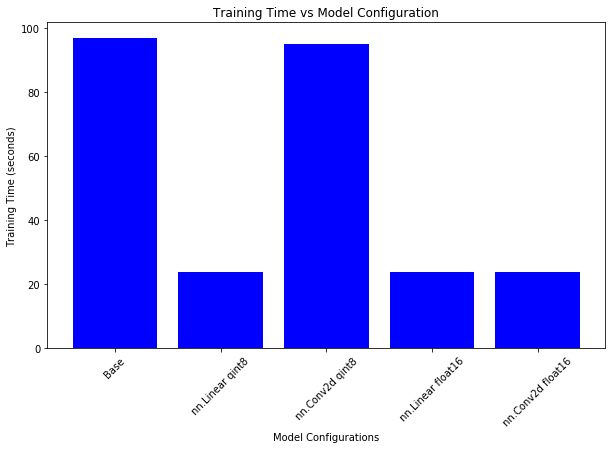

In [259]:
import matplotlib.pyplot as plt

model_configurations = [
    "Base",
    "nn.Linear qint8",
    "nn.Conv2d qint8",
    "nn.Linear float16",
    "nn.Conv2d float16"
]
training_times = [
    1 * 60 + 37, 
    24,          
    1 * 60 + 35, 
    24,           
    24       
]

plt.figure(figsize=(10, 6))
plt.bar(model_configurations, training_times, color='blue')
plt.xlabel('Model Configurations')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs Model Configuration')
plt.xticks(rotation=45)
plt.show()